In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model, standardize_dataset
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, MLP
from dev_losses import cauchy, rbf, gaussian_kernel, CustomSupCon, CustomContrastiveLoss
from losses import KernelizedSupCon

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate):
        super(MLP, self).__init__()
        
        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.BatchNorm1d(hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.Linear(input_dim_target, output_dim)
        )
        self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x, y):
        features = self.feat_mlp(x)
        targets = self.target_mlp(y)
        features = nn.functional.normalize(features, p=2, dim=1)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return features, targets

In [3]:
def mirror_conn(matrix, region_indices, vecrorize_mat = True):
    """
    Flips the connectivity of specified regions within their hemispheres. Handles both single indices and lists of indices.
    
    :param matrix: The connectivity matrix.
    :param region_indices: A single index or a list of indices for the regions.
    :return: A 3D array of modified connectivity matrices. Each "slice" corresponds to the matrix after flipping each specified region.
    """
    if not isinstance(region_indices, list):
        region_indices = [region_indices]
    
    flipped_matrices = []
    
    for index in region_indices:
        new_matrix = matrix.copy()
        hemisphere_size = matrix.shape[0] // 2
        is_left_hemisphere = index < hemisphere_size
        opposite_index = index + (-1 if is_left_hemisphere else 1) * hemisphere_size

        # Flip connectivity for the specified region within its hemisphere
        if is_left_hemisphere:
            new_matrix[index, :hemisphere_size], new_matrix[opposite_index, :hemisphere_size] = \
                new_matrix[opposite_index, :hemisphere_size].copy(), new_matrix[index, :hemisphere_size].copy()
        else:
            new_matrix[index, hemisphere_size:], new_matrix[opposite_index, hemisphere_size:] = \
                new_matrix[opposite_index, hemisphere_size:].copy(), new_matrix[index, hemisphere_size:].copy()
            
        if vecrorize_mat:
            new_matrix = sym_matrix_to_vec(new_matrix, discard_diagonal = True)
        flipped_matrices.append(new_matrix)
        
    return np.array(flipped_matrices)

In [11]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, transform = None, train=True, train_size = 0.8, test_size=None, region_indices = None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)
        targets = np.expand_dims(pd.read_csv(path_target)[target_name].values, axis = 1)        

        # Split the dataset into training and test sets
        train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       train_size = train_size,
                                                       test_size=test_size,                
                                                       random_state=random_state)
        
        if train:
            selected_indices = train_indices
        else:
            selected_indices = test_indices
        
        # Select the subset of data for the current mode (train/test)
        features = features[selected_indices]
        targets = targets[selected_indices]
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if train:
            # augmentation only in training mode
            augmented_features = np.array([self.transform(sample, region_indices = region_indices) for sample in features])

            self.n_views = self.n_views + augmented_features.shape[1]
            self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
            for sub in range(self.n_sub):
                self.features[sub, 0, :] = vectorized_feat[sub]
                self.features[sub, 1:, :] = augmented_features[sub]
        else:
            self.features = vectorized_feat
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets
    

In [12]:
def standardize_dataset(dataset):
    all_features_flat = torch.cat([dataset[i][0].view(-1, dataset[i][0].shape[-1]) for i in range(len(dataset))], dim=0)
    all_targets = torch.cat([dataset[i][1].unsqueeze(0) for i in range(len(dataset))], dim=0)
    
    features_mean = all_features_flat.mean(dim=0)
    features_std = all_features_flat.std(dim=0)
    
    features_std[features_std == 0] = 1
    standardized_features_list = []
    
    for i in range(len(dataset)):
        features = dataset[i][0].view(-1, dataset[i][0].shape[-1])
        standardized_features = (features - features_mean) / features_std
        standardized_features_list.append(standardized_features.view(dataset[i][0].shape))
    
    standardized_features = torch.stack(standardized_features_list)
    
    standardized_dataset = TensorDataset(standardized_features, all_targets)
    
    return standardized_dataset

In [13]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

In [14]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [15]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=None, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        n_views = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            # labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)
            
        view_count = features.shape[1]
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            features = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            features = features
            anchor_count = view_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, view_count)

        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*n_views, device=device).view(-1, 1),
            0
        )

        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()
    

In [17]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
# the rest is arbitrary
hidden_dim_feat = 1000
input_dim_target = 1
output_dim = 2
num_epochs = 1000

lr = 0.001 # too low values return nan loss
kernel = cauchy
batch_size = 10 # too low values return nan loss
dropout_rate = 0
weight_decay = 0

In [18]:
train_dataset = MatData("matrices.npy", "participants.csv", "age", transform = mirror_conn, region_indices = [100], train_size = 100)



In [19]:
test_dataset = MatData("matrices.npy", "participants.csv", "age", train=False, test_size = 47)

In [20]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
# torch.cuda.empty_cache()
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate).to(device)
criterion_pft = KernelizedSupCon(method='expw', temperature=0.07, base_temperature=0.07, kernel=cauchy, krnl_sigma = 1)
criterion_ptt = KernelizedSupCon(method='expw', temperature=0.07, base_temperature=0.07, kernel=cauchy, krnl_sigma = 1)

# criterion = CustomKernelizedSupCon(temperature = temperature, base_temperature = base_temperature, kernel = kernel)
# criterion = CustomSupCon('exp',temperature = temperature, base_temperature = base_temperature, kernel = kernel)

optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        bsz = targets.shape[0]
        n_views = features.shape[1]
        n_feat = features.shape[-1]
        
        features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
        features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]
        
        optimizer.zero_grad()
        out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0)) # ([bsz*5, 1], [bsz*5, 1])
        
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]
        
        loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])
        
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
        
        loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')


Epoch 0 | Mean Loss 16.469335269927978
Epoch 1 | Mean Loss 10.930840492248535
Epoch 2 | Mean Loss 7.3519645690917965
Epoch 3 | Mean Loss 6.585882997512817
Epoch 4 | Mean Loss 6.322476482391357
Epoch 5 | Mean Loss 6.207472658157348
Epoch 6 | Mean Loss 6.063387680053711
Epoch 7 | Mean Loss 5.951940059661865
Epoch 8 | Mean Loss 5.965478467941284
Epoch 9 | Mean Loss 5.9922338962554935
Epoch 10 | Mean Loss 5.928503227233887
Epoch 11 | Mean Loss 5.940913534164428
Epoch 12 | Mean Loss 5.92286229133606
Epoch 13 | Mean Loss 5.9295234203338625
Epoch 14 | Mean Loss 5.9124500274658205
Epoch 15 | Mean Loss 5.900765371322632
Epoch 16 | Mean Loss 5.883850860595703
Epoch 17 | Mean Loss 5.88899598121643
Epoch 18 | Mean Loss 5.885649108886719
Epoch 19 | Mean Loss 5.875869274139404
Epoch 20 | Mean Loss 5.870638227462768
Epoch 21 | Mean Loss 5.869984579086304
Epoch 22 | Mean Loss 5.851471281051635
Epoch 23 | Mean Loss 5.84382472038269
Epoch 24 | Mean Loss 5.8206117153167725
Epoch 25 | Mean Loss 5.77118153

Epoch 208 | Mean Loss 5.042608833312988
Epoch 209 | Mean Loss 5.089464807510376
Epoch 210 | Mean Loss 5.060083723068237
Epoch 211 | Mean Loss 5.0359166145324705
Epoch 212 | Mean Loss 5.06659083366394
Epoch 213 | Mean Loss 5.100061655044556
Epoch 214 | Mean Loss 5.102928638458252
Epoch 215 | Mean Loss 5.0709113597869875
Epoch 216 | Mean Loss 5.054097270965576
Epoch 217 | Mean Loss 5.07418303489685
Epoch 218 | Mean Loss 5.076726341247559
Epoch 219 | Mean Loss 5.055976057052613
Epoch 220 | Mean Loss 5.032170963287354
Epoch 221 | Mean Loss 5.077888298034668
Epoch 222 | Mean Loss 5.0819660186767575
Epoch 223 | Mean Loss 5.078001880645752
Epoch 224 | Mean Loss 5.10282940864563
Epoch 225 | Mean Loss 5.0788350105285645
Epoch 226 | Mean Loss 5.082896375656128
Epoch 227 | Mean Loss 5.092334461212158
Epoch 228 | Mean Loss 5.063675737380981
Epoch 229 | Mean Loss 5.079302978515625
Epoch 230 | Mean Loss 5.152772712707519
Epoch 231 | Mean Loss 5.089501953125
Epoch 232 | Mean Loss 5.050706481933593
Ep

KeyboardInterrupt: 

In [23]:
mape_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'mape')
r2_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'r2')
# results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(mape_train, r2_train)

Training target estimator
Training target estimator
1.3394337 3.079791734417192e-06


In [119]:
# results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
# results_df.to_csv('cv_results_hopkins.csv', index=False)

## Testing

In [104]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [127]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        bsz = targets.shape[0]
        n_views = 1
        n_feat = features.shape[-1]
        
        if len(features.shape) > 2:
            n_views = features.shape[1]
            features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
        features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]

        out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0))   
        
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]
        
        loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])
        
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
        
        loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])
        
        emb_features.append(out_feat[:, 0, :])
        emb_targets.append(out_target[:, 0, :])
        
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   1.37


In [128]:
emb_features = torch.row_stack(emb_features).cpu()

In [129]:
emb_targets = torch.row_stack(emb_targets).cpu()

In [130]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [131]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [132]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

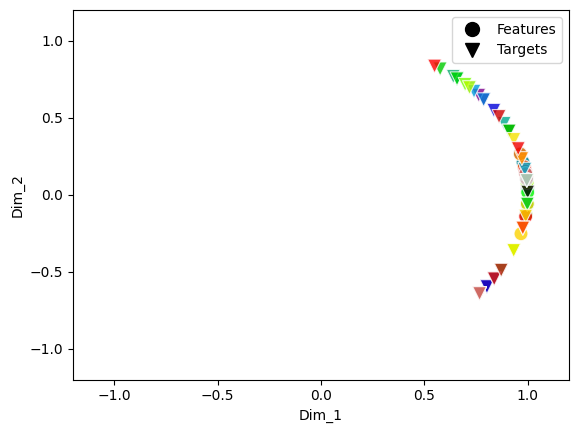

In [133]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])